# EDA: Basic Feature Extraction

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import os 
import gc 

import re 
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer 
from bs4 import BeautifulSoup

In [4]:
df = pd.read_csv("train.csv")
print("Number of data points : " , df.shape[0])

Number of data points :  404290


In [5]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: xlabel='is_duplicate'>

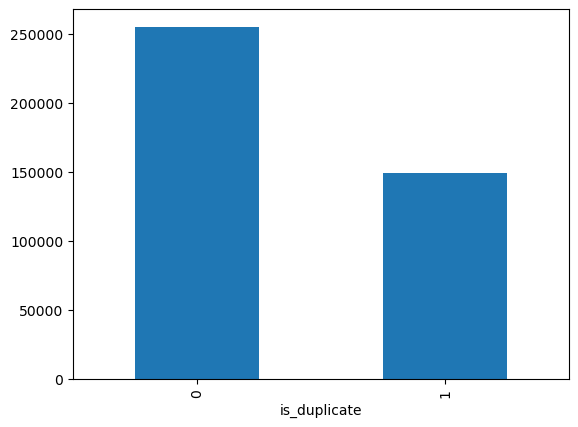

In [7]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [8]:
print("The total number of questions for training is : {}".format(len(df)))

The total number of questions for training is : 404290


In [9]:
print("Question pairs are not similiar(is_duplicate == 0):  {}%".
     format(round(df['is_duplicate'][df['is_duplicate']==0].count() / len(df)*100,2)))

Question pairs are not similiar(is_duplicate == 0):  63.08%


In [10]:
#simply
print("Question pairs that are similar are {}%". 
      format(round(df['is_duplicate'].mean() *100 , 2)))

Question pairs that are similar are 36.92%


Number of unique questions

In [11]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [12]:
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)


In [13]:
print("Total Number of unique questions are " , unique_qs)

Total Number of unique questions are  537933


In [14]:
print("Number of unique questios that appear more than one time : ", 
     qs_morethan_onetime)

Number of unique questios that appear more than one time :  111780


In [15]:
print("Maximum number of time the single question is repeated: ",max(qids.value_counts()) )

Maximum number of time the single question is repeated:  157


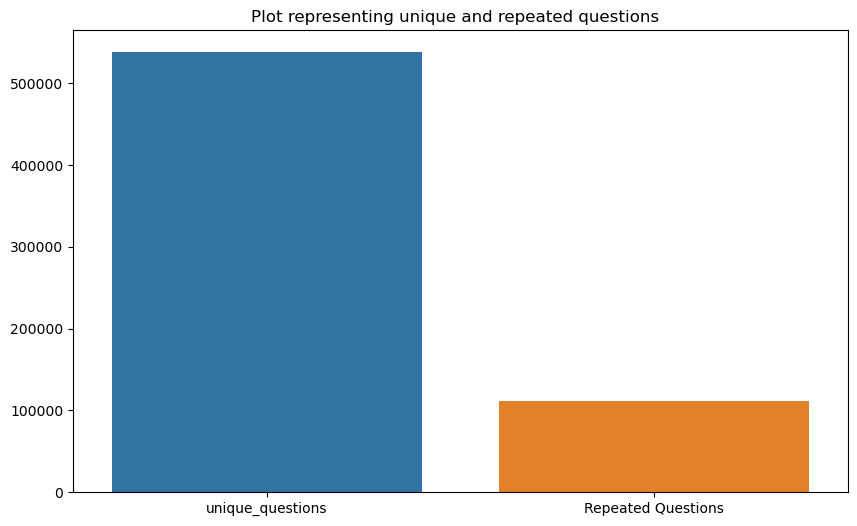

In [16]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x=x,y=y)
plt.show()

# Checking for Duplicates

In [17]:
pair_duplicates = df[['qid1' , 'qid2' , 'is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

In [18]:
print("Number of duplicate question: {}".format(
      df.shape[0]-pair_duplicates.shape[0]))

Number of duplicate question: 0


Number of occurence of each question 

Maximum number of times a single question is repeated: 157



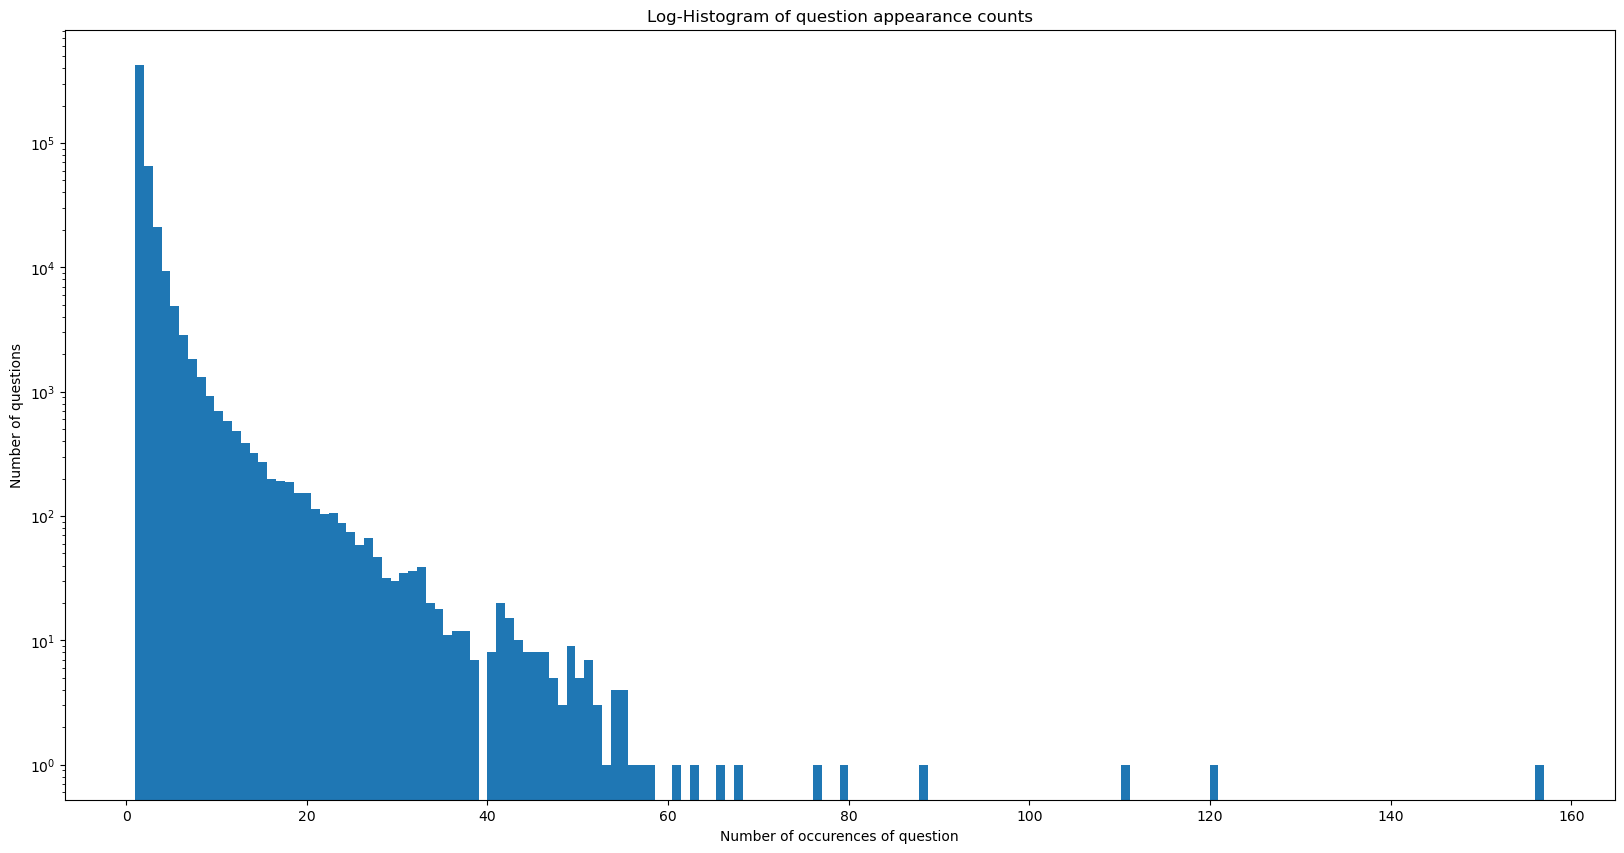

In [19]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log',)

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### Checking for NULL values

In [20]:
nan_rows = df[df.isnull().any(1)]
nan_rows

C:\Users\Roshan\AppData\Local\Temp\ipykernel_13536\167275740.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.



id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [21]:
df = df.fillna('')


In [22]:
nan_rows = df[df.isnull().any(1)]
nan_rows

C:\Users\Roshan\AppData\Local\Temp\ipykernel_13536\167275740.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.



Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

#### no more missing values

## Basic Feature Extraction (before cleaning)

In [23]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

### Analysis of some extracted features

In [24]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### Feature: word_share

C:\Users\Roshan\AppData\Local\Temp\ipykernel_13536\2505877130.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Roshan\AppData\Local\Temp\ipykernel_13536\2505877130.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='word_share', ylabel='Density'>

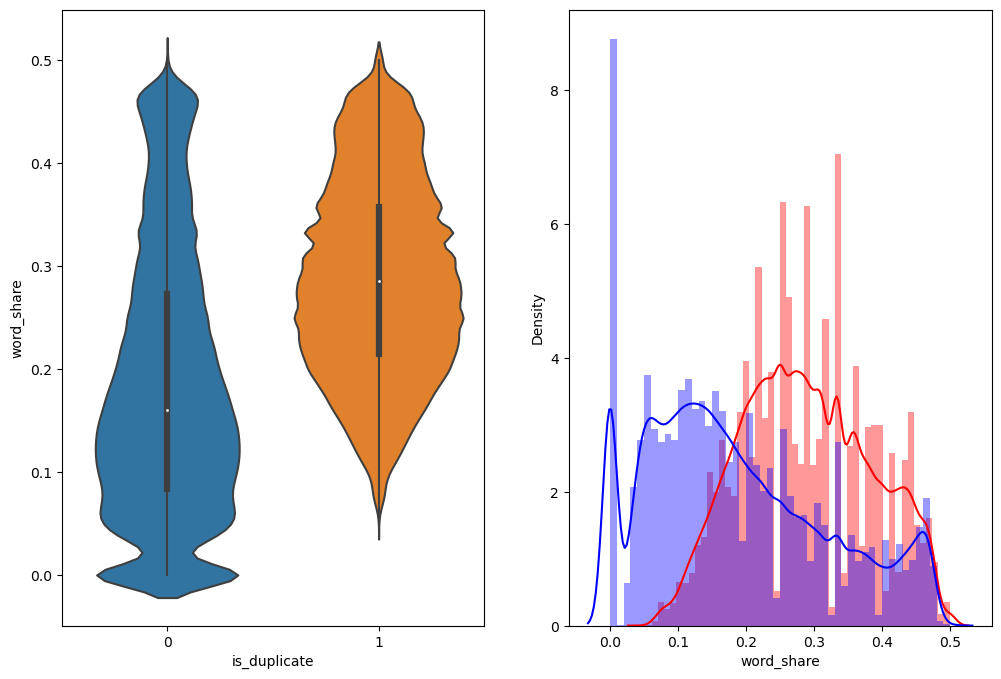

In [25]:
plt.figure(figsize= (12, 8))

plt.subplot(1,2,1)
sns.violinplot(x= "is_duplicate" , y = "word_share", data = df)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_share'], label = '1' , color='red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'] , label= '0' , color = 'blue')

>The distribution have some overlap. 

#### Feature: word_Common

C:\Users\Roshan\AppData\Local\Temp\ipykernel_13536\441858631.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Roshan\AppData\Local\Temp\ipykernel_13536\441858631.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




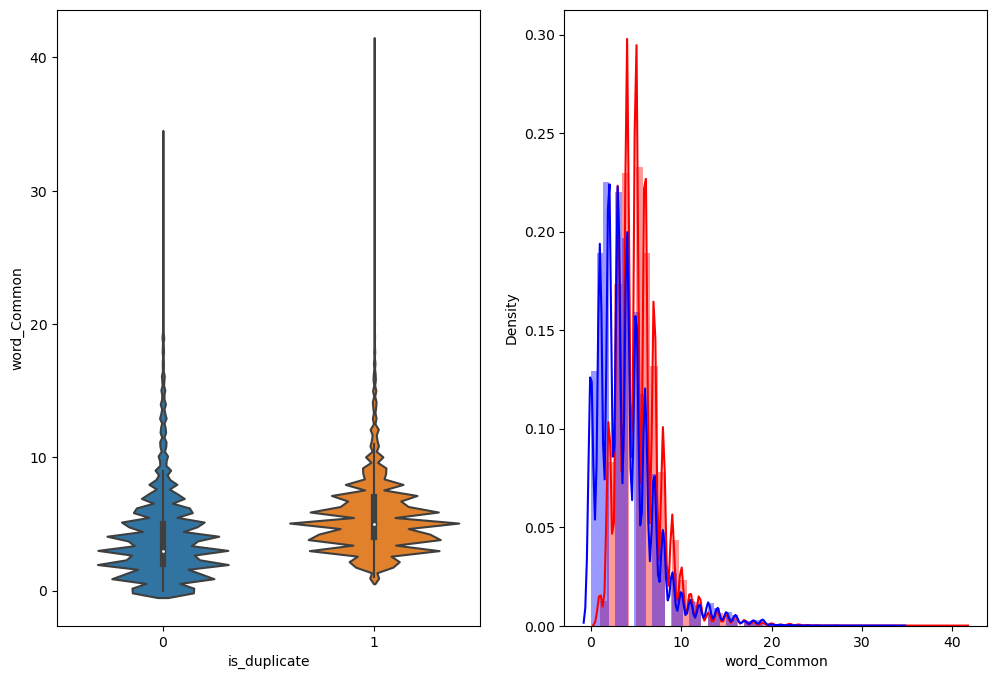

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'] , label = "0" , color = 'blue' )
plt.show()

Higly overlapping

## EDA : Advanced Feature Extraction

In [27]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image


### Preprocessing of Text

-Removing html tags
-Removing Punctuations
-Performing stemming
-Removing Stopwords
-Expanding contractions etc.

In [28]:
#To get the results in 4 decimal points
SAGE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

In [29]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000" , r"\1m" , x)
    x = re.sub(r"([0-9]+)000", r"\1k",x)
    
    porter = PorterStemmer()
    # to conver $ to word dollar
    
    pattern = re.compile('\W')
    if type(x) == type(""):
        x = re.sub(pattern , " " , x)
    if type(x)== type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x

In [30]:
#example
print(preprocess("<p> hello </p> my won't balance is $1,000,000"))


p  hello   p  my will not balance is  dollar 1m


### Advanced Feature Extraction(NLP and Fuzzy Features)

Definition:

Token: You get a token by splitting sentence a space

Stop_Word : stop words as per NLTK.

Word : A token that is not a stop_word

Features:

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))



cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))



csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))



csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))



ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))



ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))



last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])



first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])



abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))



mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2



fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [31]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    #get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([words for word in q2_tokens if word not in STOP_WORDS ])
    
    #Get the stop words in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #Get the common non-stopword in Question Pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #get the common stopwords from Question Pair 
    common_stop_count = len(q1_stops.intersection(q2_words))
    
    #get the common tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    #last of the both question is same or not
    token_features[6] = int (q1_tokens[-1] == q2_tokens[-1])
    
    #first word of both question is same or not 
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token length of both questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features
    
#get the longest Common sub string

def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))
    if len(strs) == 0:
        return 0
    else : 
        return len(strs[0]) / (min(len(a), len(b))+1)
def extract_features(df):
    #preprocessing each question
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    print("token features ...")
    
    #Merging the features with dataset
    token_features = df.apply(lambda x : get_token_features(x['question1'] , x['question2']),axis =1)
    
    df['cwc_min'] = list(map(lambda x : x[0] , token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    print("fuzzy features...")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df
    
    

In [32]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv" , encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv('train.csv')
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv" , index = False )
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

#### Plotting Word Clouds

> Creating word cloud of duplicated and non duplicated question pairs
> We can observe the most frequent occuring words

In [76]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
#np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
#np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [82]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 3335825


Word Cloud for Duplicate Question Pairs


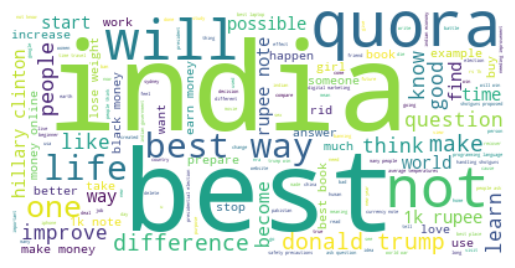

In [83]:
wc = WordCloud(background_color='white' , max_words=len(textp_w) , stopwords=stopwords)
wc.generate(textp_w)
print("Word Cloud for Duplicate Question Pairs")
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

Word Cloud for non-Duplicate Question pairs:


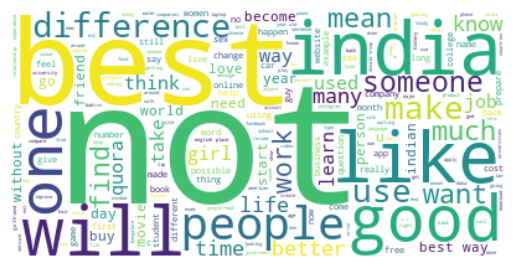

In [84]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#####  Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

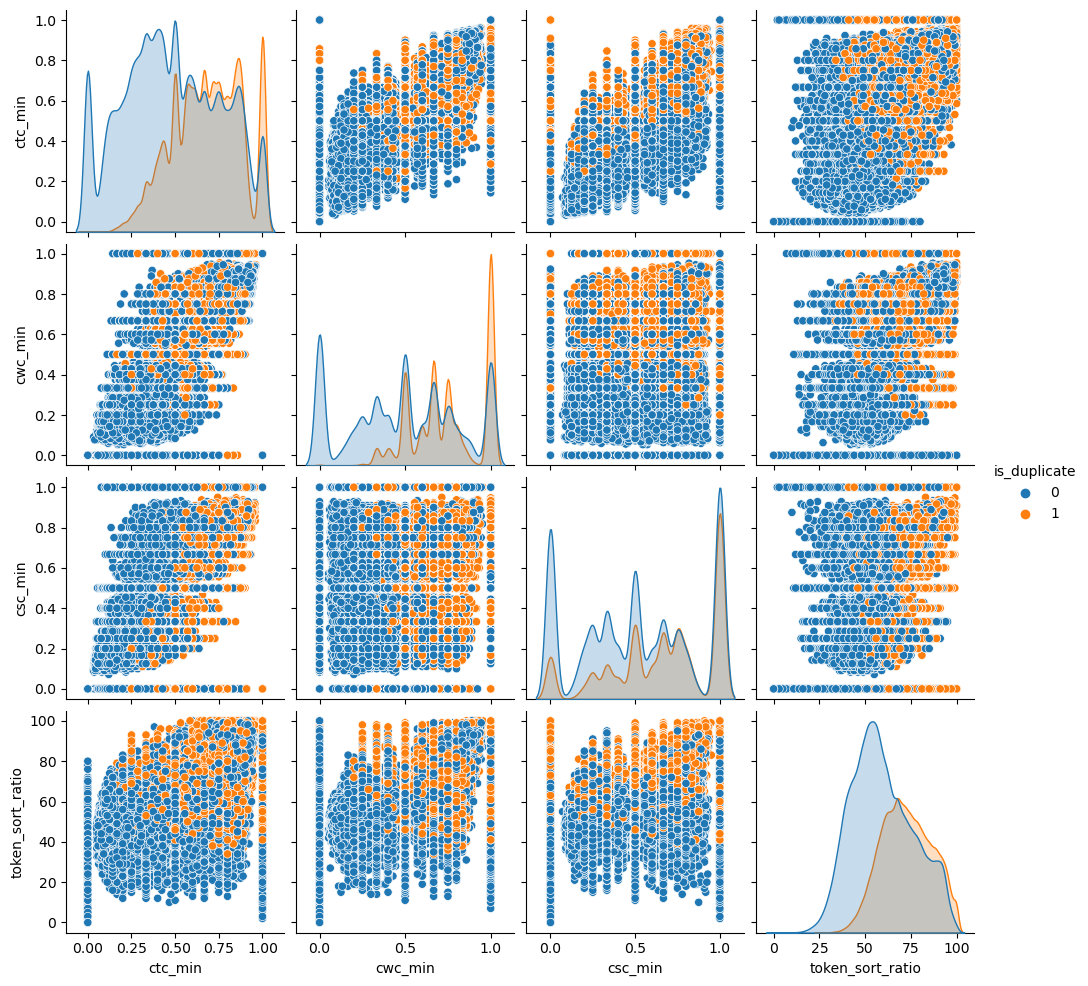

In [90]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<Axes: xlabel='token_sort_ratio', ylabel='Density'>

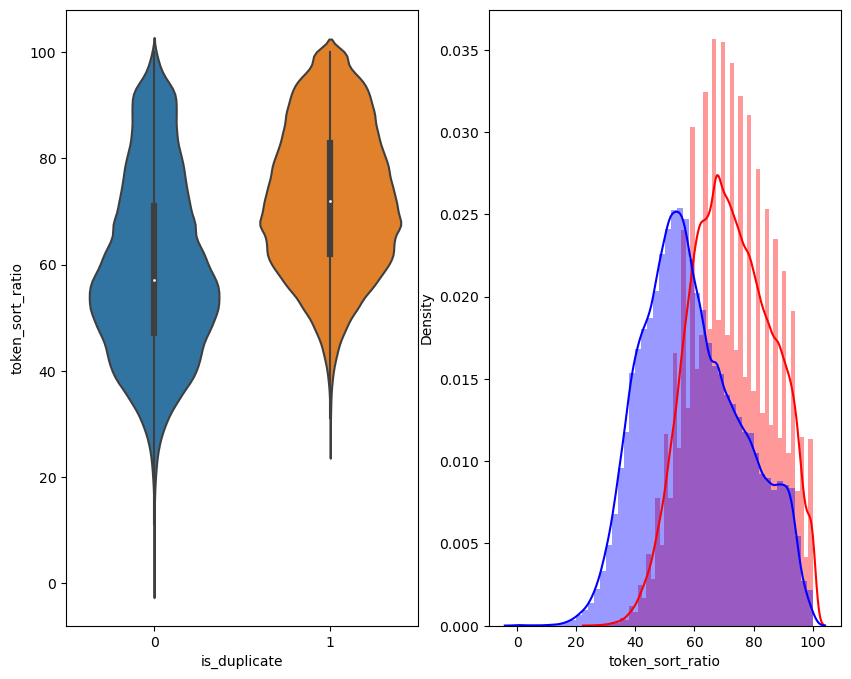

In [94]:
#distribution of token_sort_ratio
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'token_sort_ratio' , data = df )
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['token_sort_ratio'] , label = '1' ,color='red')
sns.distplot(df[df['is_duplicate'] ==0]['token_sort_ratio'] , label =2 , color = 'blue')

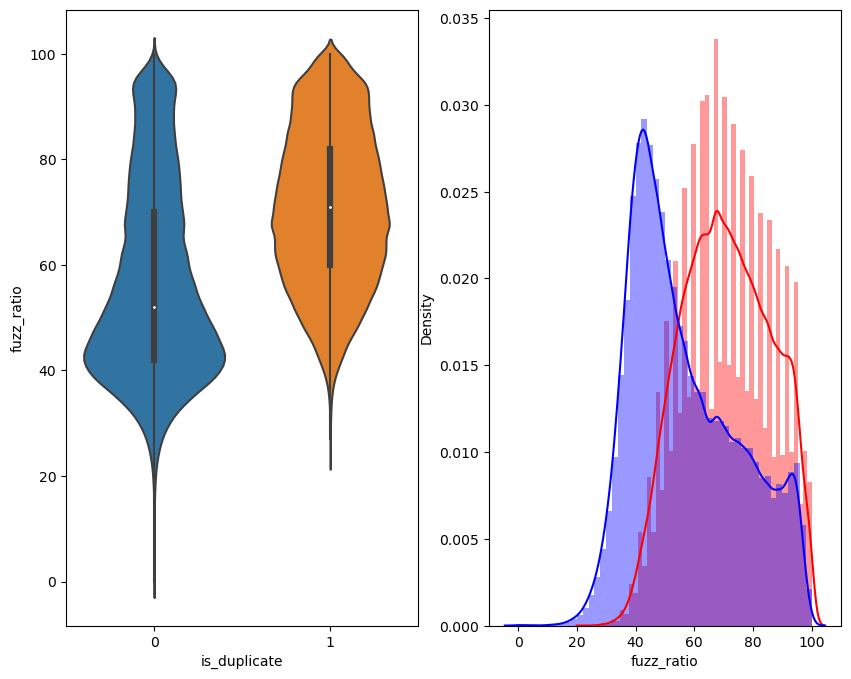

In [95]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### Visualization

In [35]:
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [39]:
tsne2d = TSNE(
    n_components=2 , 
    init = 'random' , 
    random_state=101,
    method = 'barnes_hut',
    n_iter=1000,
    verbose = 2,
    angle = 0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.067s...
[t-SNE] Computed neighbors for 10000 samples in 1.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.094219
[t-SNE] Computed conditional probabilities in 0.322s
[t-SNE] Iteration 50: error = 95.8023682, gradient norm = 0.0571264 (50 iterations in 4.600s)
[t-SNE] It

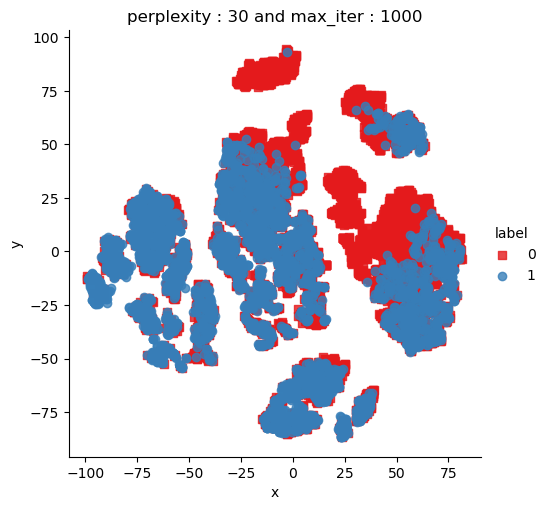

In [42]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [44]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.052s...
[t-SNE] Computed neighbors for 10000 samples in 1.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.094219
[t-SNE] Computed conditional probabilities in 0.294s
[t-SNE] Iteration 50: error = 97.1772461, gradient norm = 0.0365603 (50 iterations in 12.773s)
[t-SNE] I

In [45]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

### Featurizing text data with tfidf weighted word-vectors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm




In [2]:
import spacy

In [3]:
df = pd.read_csv('train.csv')

In [7]:
df['question1']  = df['question1'] .apply(lambda x : str(x))
df['question2']  = df['question2'] .apply(lambda x : str(x))


In [8]:
df['question1']

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
404285    How many keywords are there in the Racket prog...
404286            Do you believe there is life after death?
404287                                    What is one coin?
404288    What is the approx annual cost of living while...
404289                What is like to have sex with cousin?
Name: question1, Length: 404290, dtype: object

In [9]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Merge texts

questions = list(df['question1']) + list (df['question2'])
questions

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?',
 'Method to find separation of slits using fresnel biprism?',
 'How do I read and find my YouTube comments?',
 'What can make Physics easy to learn?',
 'What was your first sexual experience like?',
 'What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?',
 'What would a Trump presidency mean for current international 

In [15]:
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)


<808580x109679 sparse matrix of type '<class 'numpy.float64'>'
	with 8146555 stored elements in Compressed Sparse Row format>

In [16]:
word2tfidf = dict(zip(tfidf.get_feature_names_out() , tfidf.idf_))

In [17]:
word2tfidf

{'00': 10.04915924690928,
 '000': 7.304591037001674,
 '0000': 13.909888957949875,
 '000000': 13.909888957949875,
 '00000000': 13.909888957949875,
 '0000000000': 13.50442384984171,
 '0000001': 13.909888957949875,
 '00000074': 13.909888957949875,
 '0000021210': 13.909888957949875,
 '00001': 13.909888957949875,
 '0001': 13.909888957949875,
 '0002': 13.909888957949875,
 '000INR': 13.909888957949875,
 '000K': 13.909888957949875,
 '000Rs': 12.811276669281765,
 '000USD': 13.909888957949875,
 '000WebHost': 13.909888957949875,
 '000ft': 13.909888957949875,
 '000rs': 13.909888957949875,
 '000s': 13.909888957949875,
 '000webhost': 13.909888957949875,
 '001': 12.811276669281765,
 '0015': 13.909888957949875,
 '0019': 12.99359822607572,
 '002': 13.21674177738993,
 '0021': 13.909888957949875,
 '0035': 13.909888957949875,
 '003SC': 13.909888957949875,
 '005': 13.909888957949875,
 '0051': 13.50442384984171,
 '007': 13.50442384984171,
 '008': 13.50442384984171,
 '008801703772104': 13.909888957949875,
 '

In [22]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [45:43<00:00, 147.37it/s]


In [64]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [49:29<00:00, 136.13it/s]


In [65]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [66]:
dfnlp.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

In [67]:
dfppro.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

In [68]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [69]:
#dataframe of nlp features
df1.head(2)

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   

   longest_substr_ratio  
0              0.982759  
1              0.596154

In [70]:
#data before preprocessing
df2.head(2)

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0   0          1          1     66     57          14          12   
1   1          4          1     51     88           8          13   

   word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
0         10.0        23.0    0.434783           2           0  
1          4.0        20.0    0.200000           5           3

In [71]:
#questions 1 tfidf weighted word2vec
df3_q1.head()

0          1          2          3          4          5   \
0  16.463361 -45.934091   9.832647 -19.447243  16.256219 -11.408626   
1 -15.513324 -26.773417  22.476599  38.939703  31.664113  11.493576   
2 -17.676359  -9.333410  -9.743485  -9.513854   9.613585 -14.764669   
3  61.410205 -18.528259 -11.641798 -12.944759 -25.763738 -20.467962   
4 -16.935533 -43.565446  -0.564583 -44.367033 -40.639765  15.802749   

          6          7          8          9   ...         86         87  \
0  45.781352  33.793397  -0.682307  10.741596  ...  10.027314 -33.372701   
1  18.258106  56.702155   3.560213 -46.756693  ...  -6.072477  23.089771   
2  23.965156  13.467987 -18.925062   2.744790  ...  28.016300  -0.865168   
3  12.122635  10.075653  16.520064  -7.103116  ... -16.086364  -1.919414   
4  47.420133  79.964139  12.941914 -13.307732  ... -12.924408 -15.566424   

          88          89         90         91         92         93  \
0 -48.610679   23.520850 -20.693862   9.707474  44.017382  68.670248   
1 -38.483047   35.745365 -14.073059   7.308269  89.132784   3.295301   
2 -24.250924   15.859977 -19.880628 -20.721368  28.209778  41.850917   
3   3.626954   42.526902  48.064342 -28.988905  29.753628  27.724032   
4 -51.009173  103.080679 -26.997227  34.913599  89.270781  76.832059   

          94         95  
0 -17.080289  33.657361  
1   0.226582  88.639381  
2 -17.749369  30.532829  
3   1.117211  15.843518  
4   5.808165  89.445575  

[5 rows x 96 columns]

In [72]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [73]:
df3_q2

0          1          2          3          4          5   \
0       17.591981 -45.190796   5.264223 -16.323098   8.937831  -9.328999   
1      -22.684552 -72.190479  -6.707384  36.345242   8.030883  -5.487780   
2        5.474987 -16.175602  -6.273927   1.055980 -22.802814  -1.355439   
3       19.534105 -15.777413  -6.863119   4.812232 -29.383081  -6.756101   
4      -10.295480 -31.240737  10.990946   0.656096 -23.303609  -3.377757   
...           ...        ...        ...        ...        ...        ...   
404285  -7.064264 -25.037810 -21.467344   9.238776 -22.972750   2.402270   
404286   4.457236  -0.298246  -3.184480 -19.172895  -3.176289 -13.839177   
404287   1.024431  -8.039991  -4.542813   9.712707 -11.507436   2.605180   
404288 -32.414208 -25.061567 -10.607177   8.368582 -38.626970   3.072816   
404289 -24.280986   0.940490  13.439493  -1.559452 -14.497673 -18.500179   

               6          7          8          9   ...         86         87  \
0       39.247610  41.735712 -10.110290  13.893757  ...  12.478954 -30.068915   
1        8.623339  36.662616  -7.383572 -39.861679  ...   4.830299  19.611342   
2       16.201962  32.944554  -4.630614   6.233720  ...  51.079299 -11.944445   
3       -7.505578   0.548617 -17.597086 -14.904720  ...  22.016934   8.856643   
4       30.301439  16.654266  -0.161807  -3.671974  ...  -3.956318 -13.591868   
...           ...        ...        ...        ...  ...        ...        ...   
404285  21.622748  32.735927  -8.275717 -30.676690  ...  -9.402250 -24.147118   
404286  24.135007  -9.832455   8.359917 -10.696943  ...  -0.179043  11.806704   
404287   0.107580  11.385322  -1.683695  -2.336023  ...  14.998667  -8.178944   
404288  46.483947  58.826439  43.958187  -2.076026  ...  16.830851 -38.051283   
404289  35.076711   2.418102  -4.267225 -17.653052  ...  -4.019838 -10.474155   

               88          89         90         91         92          93  \
0      -47.913707   14.714811 -17.241791   6.486735  26.456941   63.701761   
1      -35.900325   45.733032  -2.857659   5.916804  82.456646   34.427442   
2      -51.070310   12.397111 -19.068659  -5.625129  48.529716   48.813838   
3       -6.845009   22.816601   0.418034 -18.978339   9.303711   41.359689   
4      -26.024702   13.573341 -10.809346  -2.419427  35.918892   36.435138   
...           ...         ...        ...        ...        ...         ...   
404285   1.401058   38.342303   2.454532  10.568294  77.414853   25.033623   
404286   2.482267   34.576990  14.386264 -17.611801  16.251113    8.280386   
404287  -8.675496   15.583266 -16.377812   8.684985  26.385004    4.476839   
404288 -61.499568  100.311596 -41.854245  -3.059444  67.098228  101.210982   
404289  -0.139636   17.834309 -11.326987   6.147537  35.895441   17.663535   

               94         95  
0      -17.887825  21.516744  
1       -0.153906  83.436959  
2       -6.016333  10.582172  
3        4.616394  32.863481  
4      -10.428509  16.641590  
...           ...        ...  
404285  -6.840319  34.849046  
404286 -17.234295  11.334302  
404287  -1.248553   6.083937  
404288  14.653620  54.353336  
404289  -0.260803  17.801768  

[404290 rows x 96 columns]

In [74]:
#storing the final features to csv file
if not os.path.isfile("final_features.csv"):
    df3_q1['id'] = df['id']
    df3_q2['id'] = df['id']
    df1 = df1.merge(df2 , on = 'id' , how= 'left')
    df2 = df3_q1.merge(df3_q2 , on = 'id' , how = 'left')
    result = df1.merge(df2 , on = 'id', how = 'left')
    result.to_csv('final_features.csv')

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine  # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss  # Updated import
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve


## Machine Learning Model

### Reading data from file and storing in sql table

In [ ]:
#creating the db file from csv
if not os.path.isfile('train.db'):
    disk_engine  = create_engine("sqlite:///train.db")
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j +=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data' , disk_engine , if_exists='append')
        index_start = df.index[-1] + 1

In [82]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [83]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [108]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 30000;", conn_r)
        conn_r.commit()
        conn_r.close()

In [109]:
data

index  Unnamed: 0      id is_duplicate            cwc_min  \
0      134109    134107.0  134107            0                0.0   
1      148662    148660.0  148660            0                0.0   
2      394438    214436.0  214436            1  0.999950002499875   
3      501632    321630.0  321630            1   0.33332222259258   
4      416108    236106.0  236106            0  0.249997916684028   
...       ...         ...     ...          ...                ...   
29995  509490    329488.0  329488            0                0.0   
29996   40150     40148.0   40148            0  0.749981250468738   
29997  160192    160190.0  160190            1  0.999975000624984   
29998  363836    183834.0  183834            0  0.499987500312492   
29999  927284    387282.0  387282            0  0.399992000159997   

                 cwc_max            csc_min            csc_max  \
0                    0.0                0.0                0.0   
1                    0.0   0.33332222259258  0.249993750156246   
2       0.66664444518516  0.999950002499875  0.285710204139941   
3       0.33332222259258  0.999975000624984  0.999975000624984   
4      0.249997916684028  0.727266115762584  0.727266115762584   
...                  ...                ...                ...   
29995                0.0   0.33332222259258   0.14285510206997   
29996  0.749981250468738  0.999975000624984  0.999975000624984   
29997  0.999975000624984  0.749981250468738  0.749981250468738   
29998  0.285710204139941                0.0                0.0   
29999  0.285710204139941  0.333327777870369  0.222219753113854   

                 ctc_min             ctc_max  ...               374_y  \
0                    0.0                 0.0  ...  0.0246419906616211   
1      0.166663888935184    0.14285510206997  ...   -1.99897715449333   
2      0.999975000624984   0.333330555578704  ...    8.68715104460716   
3      0.714275510349852   0.714275510349852  ...    5.69352507591248   
4      0.478258790179173    0.43999824000704  ...    14.8551136795431   
...                  ...                 ...  ...                 ...   
29995  0.124998437519531  0.0769224852116522  ...    11.0714150071144   
29996  0.874989062636717   0.874989062636717  ...   -1.72579485923052   
29997  0.874989062636717   0.874989062636717  ...   -4.44087083637714   
29998  0.222219753113854   0.142856122456268  ...   0.253155626356602   
29999  0.266664888900741   0.249998437509766  ...     29.535286443308   

                   375_y              376_y              377_y  \
0      0.751557663083077    19.919412791729  -1.86536403931677   
1       5.85916814953089   4.51690830662847  0.945494226180017   
2       14.9622259289026   2.98713918030262  -2.10804457217455   
3        17.985652923584   4.47489641606808  -7.70711362361908   
4       8.26687268167734   4.48964726924896   15.2489311397076   
...                  ...                ...                ...   
29995   5.03616802021861   9.76377001404762  -8.66047856211662   
29996   14.1340927407146   13.1216236492619  -8.86777073377743   
29997    6.4752255231142  -6.82674130517989  0.405756649095565   
29998   7.17705284059048   2.91940727829933  -1.04532220959663   
29999   10.7537931203842  -4.19224507850595  -11.7310421615839   

                   378_y              379_y              380_y  \
0      -3.88245689868927  -3.68661843985319  -4.94669185578823   
1       10.0304578244686   3.29347709566355   4.45660692453384   
2       2.27825861051679   4.04079092293978  -13.7925065383315   
3       4.86156836152077   5.15525883436203  -11.6233084797859   
4       31.2132841646671   6.38703316450119  -29.4725397638977   
...                  ...                ...                ...   
29995   7.61558515578508     8.745406717062  -12.9258165061474   
29996   9.98193377256393   13.6592286154628  -7.52589532732964   
29997   12.2159165143967  -7.88408971577883  -4.92993175983429   
29998   3.82100315392017   2.92497099936008  -13.4407592

In [110]:
data.drop(data.index[0] , inplace = True)

In [111]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

## Converting strings to numerics

In [115]:
cols = list(data.columns)
cols


['cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio',
 'freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 '0_x',
 '1_x',
 '2_x',
 '3_x',
 '4_x',
 '5_x',
 '6_x',
 '7_x',
 '8_x',
 '9_x',
 '10_x',
 '11_x',
 '12_x',
 '13_x',
 '14_x',
 '15_x',
 '16_x',
 '17_x',
 '18_x',
 '19_x',
 '20_x',
 '21_x',
 '22_x',
 '23_x',
 '24_x',
 '25_x',
 '26_x',
 '27_x',
 '28_x',
 '29_x',
 '30_x',
 '31_x',
 '32_x',
 '33_x',
 '34_x',
 '35_x',
 '36_x',
 '37_x',
 '38_x',
 '39_x',
 '40_x',
 '41_x',
 '42_x',
 '43_x',
 '44_x',
 '45_x',
 '46_x',
 '47_x',
 '48_x',
 '49_x',
 '50_x',
 '51_x',
 '52_x',
 '53_x',
 '54_x',
 '55_x',
 '56_x',
 '57_x',
 '58_x',
 '59_x',
 '60_x',
 '61_x',
 '62_x',
 '63_x',
 '64_x',
 '65_x',
 '66_x',
 '67_x',
 '6

In [116]:
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [117]:
y_true = list(map(int , y_true.values))

### Random train test split

In [118]:
X_train ,X_test , y_train , y_test = train_test_split(data , y_true ,stratify = y_true , test_size = 0.3 )

In [119]:
print("Number of data points in train data : ", X_train.shape)
print("Number of data points in test data:" , X_test.shape)

Number of data points in train data :  (20999, 794)
Number of data points in test data: (9000, 794)


In [120]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr =Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0:" , int(test_distr[0])/test_len , 'Class 1:' , int(test_distr[1])/test_len)


---------- Distribution of output variable in train data ----------
Class 0:  0.6275536930330016 Class 1:  0.37244630696699843
---------- Distribution of output variable in test data ----------
Class 0: 0.6275555555555555 Class 1: 0.37244444444444447


In [142]:
def plot_confusion_matrix(test_y , predict_y):
    C = confusion_matrix(test_y , predict_y)
    #Recall
    A =(((C.T)/(C.sum(axis=1))).T)
    #Precision 
    B = C / C.sum(axis = 0 )
    
    plt.figure(figsize=(25,6))
    
    labels = [1,2]
    #representing A, B , C in heatmap format
    
    cmap = sns.light_palette("blue")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion Matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


## Building the random model(Finding the wrost case log-loss)

Log loss on Test data using Random model 0.88539836564207


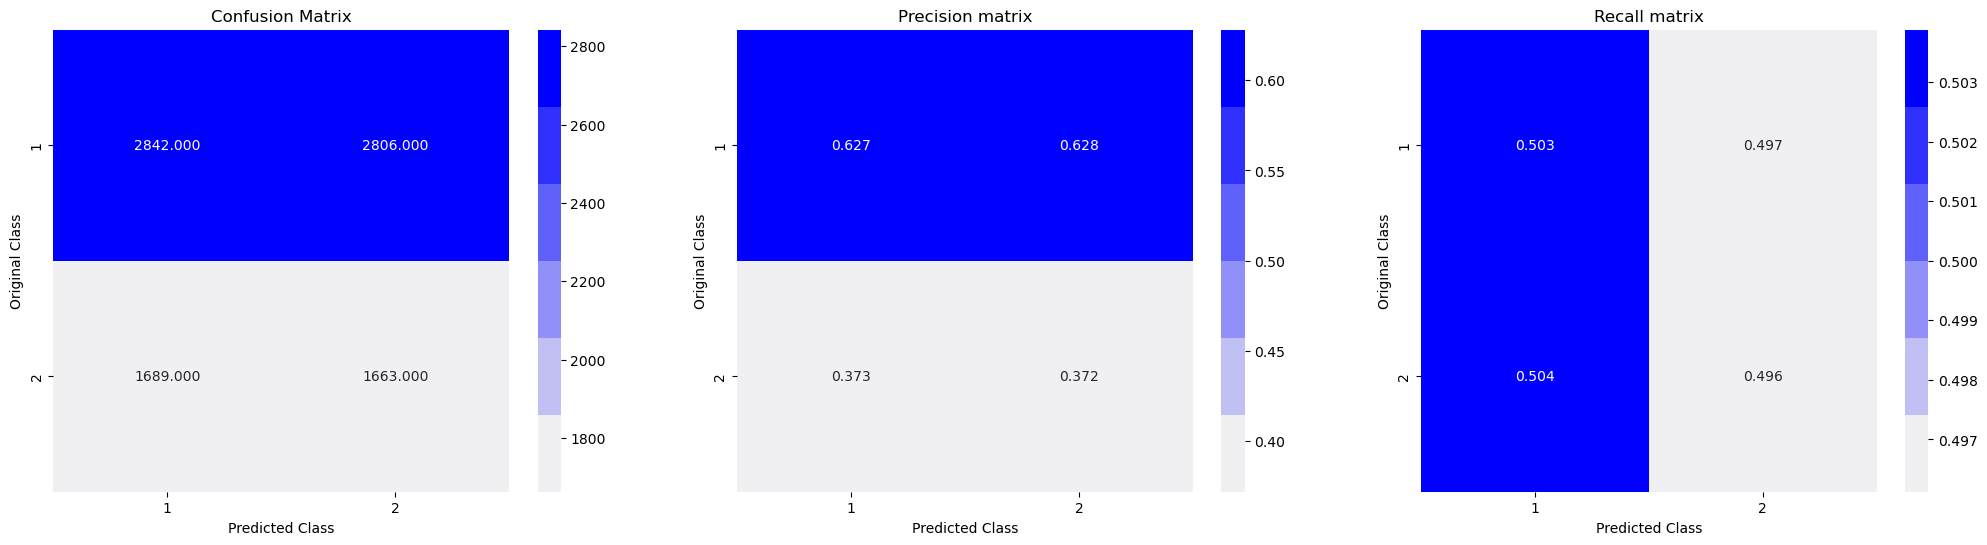

In [143]:
predicted_y  = np.zeros((test_len , 2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test data using Random model" , log_loss(y_test , predicted_y , eps = 1e-15))

predicted_y = np.argmax(predicted_y , axis = 1)

plot_confusion_matrix(y_test , predicted_y)

Here, we conclude that the wrost log-loss value is ~0.8854
We have to minimize it.

## Logistic Regression with hyperparameter tuning

In [144]:
alpha = [10**x for x in range(-5 ,2)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [146]:
log_error_array = []

for i in alpha :
    clf = SGDClassifier(alpha = i, penalty='l2' , loss = 'log' , random_state=42) 
    clf.fit(X_train , y_train)
    sig_clf = CalibratedClassifierCV(clf , method='sigmoid')
    sig_clf.fit(X_train , y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test , predict_y , labels=clf.classes_ , eps = 1e-15))
    print('For values of alpha = ' , i ,"The log loss is :" ,log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    

For values of alpha =  1e-05 The log loss is : 0.6602438580217856
For values of alpha =  0.0001 The log loss is : 0.48214865149147723
For values of alpha =  0.001 The log loss is : 0.4843729405162295
For values of alpha =  0.01 The log loss is : 0.48152518065971356
For values of alpha =  0.1 The log loss is : 0.4733578726727112
For values of alpha =  1 The log loss is : 0.4897251008670058
For values of alpha =  10 The log loss is : 0.5235114900789629


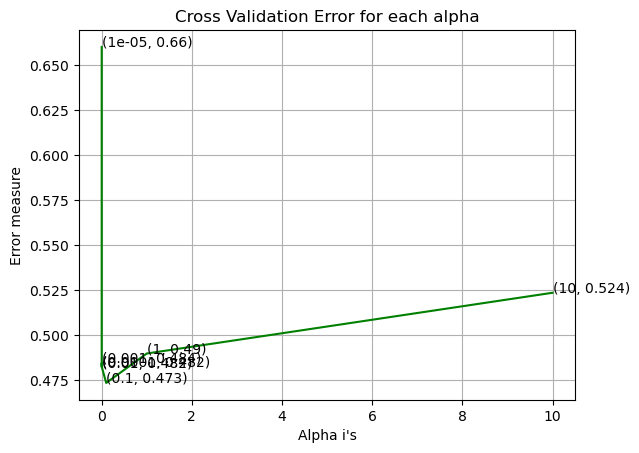

In [170]:
fig , ax = plt.subplots()
ax.plot(alpha , log_error_array , c ='g')

for i,txt in  enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i] , np.round(txt, 3)), (alpha[i] , log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.1 The train log loss is: 0.44563740355766446
For values of best alpha =  0.1 The test log loss is: 0.4733578726727112
Total number of data points : 9000


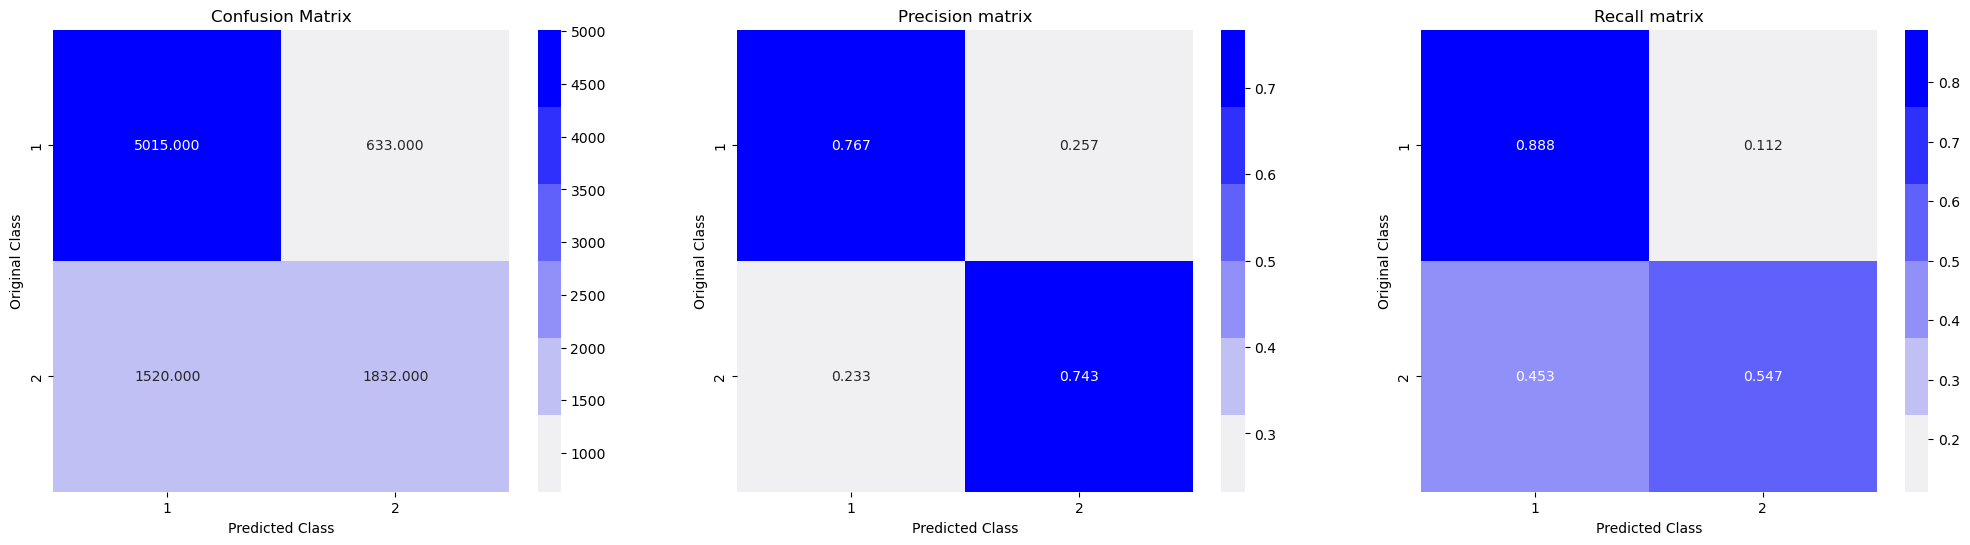

In [174]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha] , penalty='l2' , loss = 'log', random_state =42 )
clf.fit(X_train , y_train)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(X_train , y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


## Linear SVM with hyperparamer tuning

In [178]:
alpha = [10 **x  for x in range(-5,2)]
log_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i , penalty='l1' , loss= 'hinge' , random_state=42)
    clf.fit(X_train , y_train)
    sig_clf = CalibratedClassifierCV(clf , method= 'sigmoid')
    sig_clf.fit(X_train , y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test , predict_y , labels = clf.classes_,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    


For values of alpha =  1e-05 The log loss is: 0.6602438580217856
For values of alpha =  0.0001 The log loss is: 0.6602438580217856
For values of alpha =  0.001 The log loss is: 0.6602438580217856
For values of alpha =  0.01 The log loss is: 0.5908325110719121
For values of alpha =  0.1 The log loss is: 0.579598548391327
For values of alpha =  1 The log loss is: 0.6249173170547581
For values of alpha =  10 The log loss is: 0.6564568583359724


For values of best alpha =  0.1 The train log loss is: 0.5731102885171454
For values of best alpha =  0.1 The test log loss is: 0.579598548391327
Total number of data points : 9000


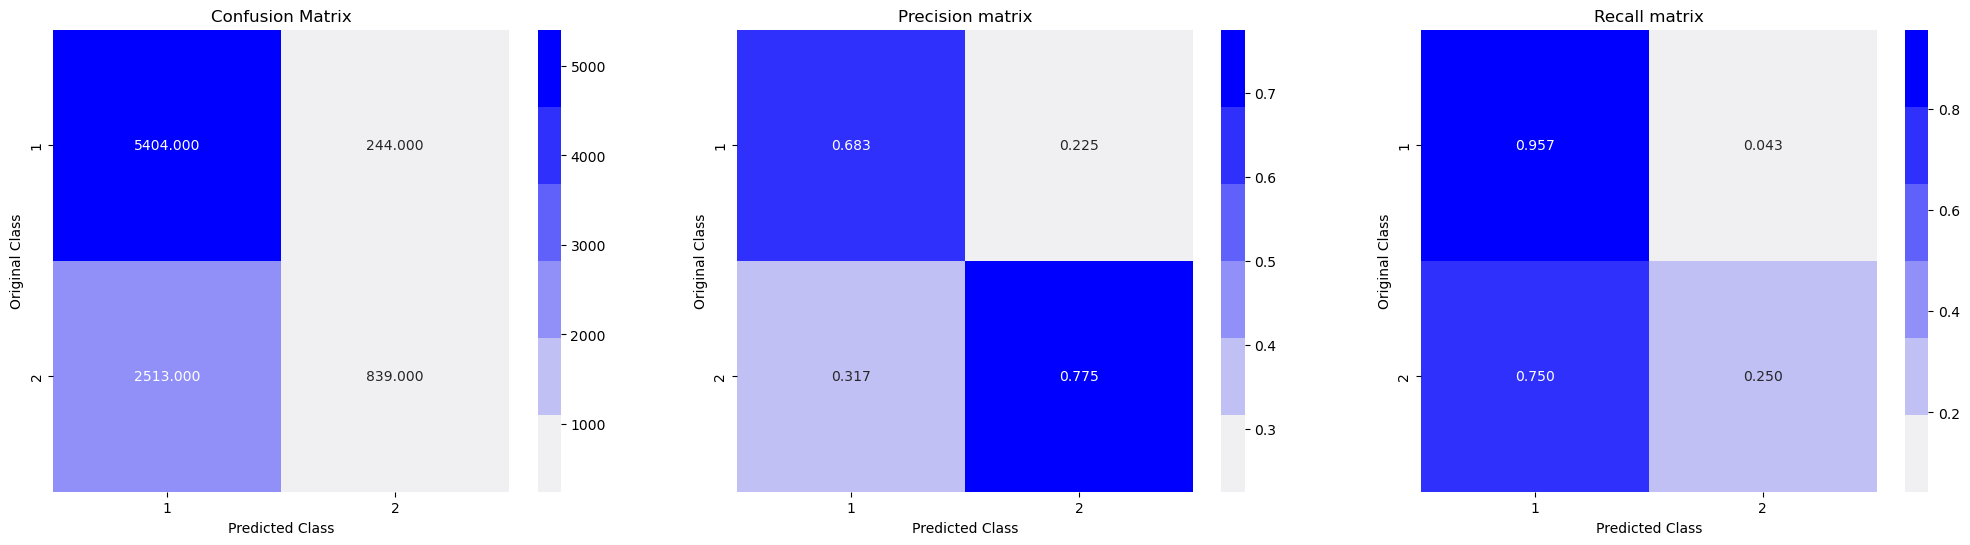

In [180]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XG Boost 

In [183]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train , label= y_train)
d_test = xgb.DMatrix(X_test , label = y_test)

watchlist = [(d_train , 'train'), (d_test , 'valid')]
bst = xgb.train(params , d_train , 400 , watchlist , early_stopping_rounds=20 , verbose_eval = 10)
xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.65275	valid-logloss:0.65320
[10]	train-logloss:0.58925	valid-logloss:0.59310
[20]	train-logloss:0.54286	valid-logloss:0.54829
[30]	train-logloss:0.50853	valid-logloss:0.51522
[40]	train-logloss:0.48196	valid-logloss:0.48979
[50]	train-logloss:0.46091	valid-logloss:0.46964
[60]	train-logloss:0.44425	valid-logloss:0.45354
[70]	train-logloss:0.43097	valid-logloss:0.44087
[80]	train-logloss:0.41996	valid-logloss:0.43026
[90]	train-logloss:0.41096	valid-logloss:0.42152
[100]	train-logloss:0.40343	valid-logloss:0.41428
[110]	train-logloss:0.39695	valid-logloss:0.40818
[120]	train-logloss:0.39142	valid-logloss:0.40300
[130]	train-logloss:0.38672	valid-logloss:0.39881
[140]	train-logloss:0.38264	valid-logloss:0.39552
[150]	train-logloss:0.37913	valid-logloss:0.39265
[160]	train-logloss:0.37582	valid-logloss:0.38992
[170]	train-logloss:0.37305	valid-logloss:0.38774
[180]	train-logloss:0.37044	valid-logloss:0.38573
[190]	train-logloss:0.36783	valid-logloss:0.38379
[200]	train

Total number of data points : 9000


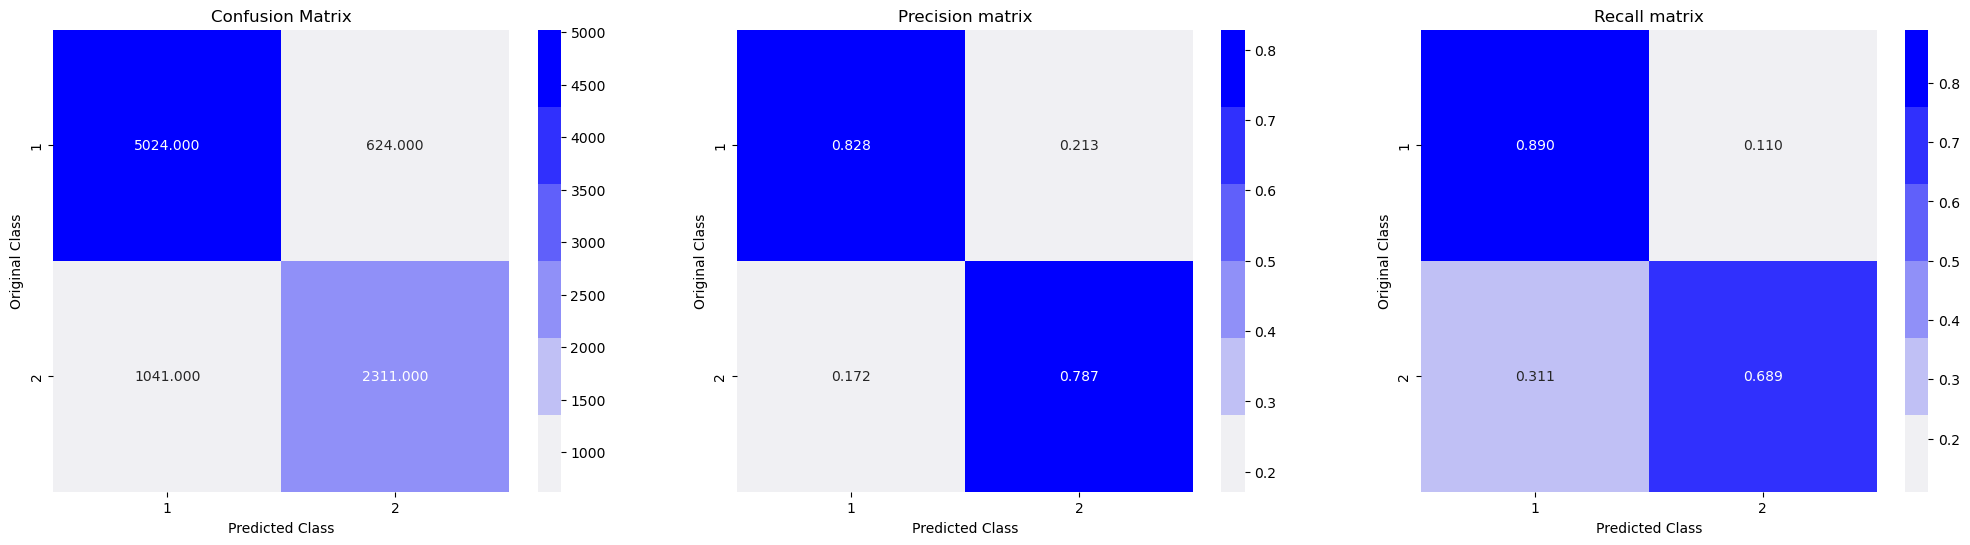

In [184]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)